#**COMPETENCIA**

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

Submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). The RMSPE is calculated as

$\textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2}$

where y_i denotes the sales of a single store on a single day and yhat_i denotes the corresponding prediction. Any day and store with 0 sales is ignored in scoring.



#**DESARROLLO**

## IMPORTAMOS LIBRERIAS Y MONTAMOS A DRIVE

In [ ]:
#Cargamos el drive para analizar el archivo csv

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

%cd drive
%cd Shareddrives
%cd Redes neuronales
%cd TP2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive'
/content/drive/Shareddrives/Redes neuronales/TP2
[Errno 2] No such file or directory: 'Shareddrives'
/content/drive/Shareddrives/Redes neuronales/TP2
[Errno 2] No such file or directory: 'Redes neuronales'
/content/drive/Shareddrives/Redes neuronales/TP2
[Errno 2] No such file or directory: 'TP2'
/content/drive/Shareddrives/Redes neuronales/TP2


In [ ]:
import pandas as pd
!pip install pandas_summary
from pandas_summary import DataFrameSummary
!pip install isoweek
from isoweek import Week
import numpy as np
import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn_pandas import DataFrameMapper
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Dense, Concatenate
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
PATH = '/content/drive/Shareddrives/Redes neuronales/TP2/kaggle-rossmann-master/rossmann/'

In [ ]:
#importamos archivos
table_names = ['train', 'test', 'store', 'store_states', 'state_names', 'googletrend', 'weather']
train, test, store, store_states, state_names, googletrend, weather = dfs = [pd.read_csv(PATH + fname+'.csv', 
                                                                             low_memory=False) for fname in table_names]

##PREPROCESAMIENTO

###Datos tipo NaN

Nos fijamos qué tipos de datos hay en 'Open'

In [ ]:
print(test['Open'].unique())

[ 1. nan  0.]


Como encontramos un NaN, lo vamos a reemplazar

In [ ]:
aux = test
aux.loc[aux['Open'].isna(), 'Open']

479     NaN
1335    NaN
2191    NaN
3047    NaN
4759    NaN
5615    NaN
6471    NaN
7327    NaN
8183    NaN
9039    NaN
10751   NaN
Name: Open, dtype: float64

In [ ]:
aux[aux['Open'].isna()]['DayOfWeek']

479      4
1335     3
2191     2
3047     1
4759     6
5615     5
6471     4
7327     3
8183     2
9039     1
10751    6
Name: DayOfWeek, dtype: int64

In [ ]:
(test[test['Open'].isna()]['DayOfWeek'] != 7)*1.0

479      1.0
1335     1.0
2191     1.0
3047     1.0
4759     1.0
5615     1.0
6471     1.0
7327     1.0
8183     1.0
9039     1.0
10751    1.0
Name: DayOfWeek, dtype: float64

A continuación, teniendo en cuenta que las tiendas abrirán todos los días de la semana salvo los domingos (día nro 7) se transforman los valores NaN de la columna 'Open' a 1 (es decir, que abre la tienda) en los casos que correspondan. Para los días domingos por el momento permanecen como NaN.

In [ ]:
test.loc[test['Open'].isna(), 'Open'] = (test[test['Open'].isna()]['DayOfWeek'] != 7)*1.0

Nos fijamos lo mismo para CompetitionOpenSinceYear

In [ ]:
print(store['CompetitionOpenSinceYear'].unique())

[2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]


Además de presentar datos tipo NaN, también notamos que el espectro de años es muy grande. Para evitar entonces outliers  se establece como año mínimo 1990:

In [ ]:
store.loc[store['CompetitionOpenSinceYear'].isna() | (store['CompetitionOpenSinceYear']<1990), 'CompetitionOpenSinceYear'] = np.int32(1990)
store.loc[store['CompetitionOpenSinceMonth'].isna() | (store['CompetitionOpenSinceYear']<1990), 'CompetitionOpenSinceMonth'] = np.int32(1)

Checkeamos si hay NaN values en 'CompetitionDistance'

In [ ]:
store['CompetitionDistance'].isnull().values.any()

True

Efectivamente hay NaN values, con lo cual se procede a reemplazar estos valores por el valor máximo:

In [ ]:
print(store['CompetitionDistance'].max(), store['CompetitionDistance'].mean(), store['CompetitionDistance'].min())
store.loc[store['CompetitionDistance'].isna(), 'CompetitionDistance'] = store['CompetitionDistance'].max()

75860.0 5404.901079136691 20.0


Teniendo en cuenta que 'Promo2SinceWeek' describe el año y la semana calendario en que la tienda comenzó a participar en Promo2, reemplazamos los NaN values de 'Promo2SinceWeek': si no tiene Promo2 entonces la semana en donde empezó es cero. Se tendrá de esta forma una variable del tipo categórica

In [ ]:
store.loc[store['Promo2SinceWeek'].isna() & (store['Promo2'] == 0), 'Promo2SinceWeek'] = np.int32(1)
store.loc[store['Promo2SinceYear'].isna() & (store['Promo2'] == 0), 'Promo2SinceYear'] = np.int32(1990)
store.loc[store['PromoInterval'].isna() & (store['Promo2'] == 0), 'PromoInterval'] = '-'

In [ ]:
print(store['Promo2SinceWeek'].unique())
print(store['Promo2SinceYear'].unique())
print(store['PromoInterval'].unique())
print(store['Promo2'].unique())

[ 1. 13. 14. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35. 23.
 48. 36. 50. 44. 49. 28.]
[1990. 2010. 2011. 2012. 2009. 2014. 2015. 2013.]
['-' 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
[0 1]


Se agregan datos externos del clima. Suponemos para ello que son días tranquilos. Estos podrían mejorar la predicción, sin embargo no se van a utilizar. 

In [ ]:
weather.loc[weather['Max_VisibilityKm'].isna(), 'Max_VisibilityKm'] = weather['Max_VisibilityKm'].max()
weather.loc[weather['Mean_VisibilityKm'].isna(), 'Mean_VisibilityKm'] = weather['Mean_VisibilityKm'].max()
weather.loc[weather['Min_VisibilitykM'].isna(), 'Min_VisibilitykM'] = weather['Min_VisibilitykM'].max()
weather.loc[weather['Max_Gust_SpeedKm_h'].isna(), 'Max_Gust_SpeedKm_h'] = weather['Max_Gust_SpeedKm_h'].min()
weather.loc[weather['CloudCover'].isna(), 'CloudCover'] = weather['CloudCover'].min()
weather.loc[weather['Events'].isna(), 'Events'] = 'Sunny'

###Formato fechas

In [ ]:
print(store['CompetitionOpenSinceYear'].unique())
print(store['CompetitionOpenSinceMonth'].unique())
print(store['Promo2SinceWeek'].unique())
print(store['Promo2SinceYear'].unique())

[2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011. 1990. 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1995. 2001. 1994. 1998.]
[ 9. 11. 12.  4. 10.  8.  1.  3.  6.  5.  2.  7.]
[ 1. 13. 14. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35. 23.
 48. 36. 50. 44. 49. 28.]
[1990. 2010. 2011. 2012. 2009. 2014. 2015. 2013.]


Pasamos a fecha algunas columnas para despues poder ponerla en días respecto a fecha. Primero nos aseguramos que los datos sean tipo int:

In [ ]:
#Reformateamos
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].astype(np.int32)
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].astype(np.int32)
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].astype(np.int32)
store['Promo2SinceYear'] = store['Promo2SinceYear'].astype(np.int32)

Creamos una nueva columna con fecha de apertura en formato de fecha (se toma como día inicial de la competencia al día 15, sin embargo no importa el valor inicial que se tome ya que no es relevante)


In [ ]:
store['CompetitionOpenSince'] = pd.to_datetime(store.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 15), axis=1))

In [ ]:
store["Promo2Since"] = pd.to_datetime(store.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))

### Join de tablas

Definimos función de join para unir ambas bases de datos. En la misma 'left' y 'right' corresponden a las tablas que se van a unir, mientras que 'left_on' y 'right_on' corresponden a las columnas que deben coincidir para unir las tablas:

In [ ]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

Primero unimos las tablas agregadas: weather y state_names

In [ ]:
weather = join_df(weather, state_names, "file", "StateName")

Para la tabla correspondiente a 'googletrend' se reformatean los datos en los que se presentan caracteres que no son del tipo numérico que pueden afectar al procesamiento de datos ('-','_'). Estos se toman como divisores de datos.

In [ ]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]

In [ ]:
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]

Se calculan tendencias de google sobre cantidad de visitas por estado:

In [ ]:
googletrend['State'].value_counts()

SL    148
HH    148
NI    148
NW    148
SN    148
SH    148
TH    148
RP    148
BY    148
BE    148
BW    148
HE    148
ST    148
Name: State, dtype: int64

Observamos los estados presentes:

In [ ]:
state_names['State']

0        BW
1        BY
2        BE
3        BB
4        HB
5        HH
6        HE
7        MV
8     HB,NI
9        NW
10       RP
11       SL
12       SN
13       ST
14       SH
15       TH
Name: State, dtype: object

Notamos que en el índice número 8 hay dos estados presentes, con lo cual se opta por uno de los dos ('NI') para modificarlo en google trend (a 'HB,NI') para que coincida con la otra tabla:

In [ ]:
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

Generamos una función para separar el año del mes y del día dentro de una fecha, ya que las tres variables van a resultar interesantes para analizar individualmente:

In [ ]:
#Función para separar fechas en año mes y día
def add_datepart(df):
    df.Date = pd.to_datetime(df.Date)
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Week"] = df.Date.dt.week
    df["Day"] = df.Date.dt.day
    
add_datepart(weather)
add_datepart(googletrend)
add_datepart(train)
add_datepart(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


Dentro del archivo googletrend se ven los datos de los distintos estados. Sin embargo se decide optar por la variable global de Alemania, cuyo nombre es 'Rossmann_DE':

In [ ]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Imprimimos dicha tabla para ver qué tipo de información presenta

In [ ]:
trend_de

,file,week,trend,Date,State,Year,Month,Week,Day
148,Rossmann_DE,2012-12-02 - 2012-12-08,77,2012-12-02,None,2012,12,48,2
149,Rossmann_DE,2012-12-09 - 2012-12-15,76,2012-12-09,None,2012,12,49,9
150,Rossmann_DE,2012-12-16 - 2012-12-22,85,2012-12-16,None,2012,12,50,16
151,Rossmann_DE,2012-12-23 - 2012-12-29,59,2012-12-23,None,2012,12,51,23
152,Rossmann_DE,2012-12-30 - 2013-01-05,61,2012-12-30,None,2012,12,52,30
...,...,...,...,...,...,...,...,...,...
291,Rossmann_DE,2015-08-30 - 2015-09-05,78,2015-08-30,None,2015,8,35,30
292,Rossmann_DE,2015-09-06 - 2015-09-12,71,2015-09-06,None,2015,9,36,6
293,Rossmann_DE,2015-09-13 - 2015-09-19,77,2015-09-13,None,2015,9,37,13
294,Rossmann_DE,2015-09-20 - 2015-09-26,67,2015-09-20,None,2015,9,38,20


Sin embargo, las columnas que nos van a resultar de interés son las correspondientes al año, el mes, la semana y el día por separado

In [ ]:
trend_de[['Date', 'Year','Month','Week','Day']]

,Date,Year,Month,Week,Day
148,2012-12-02,2012,12,48,2
149,2012-12-09,2012,12,49,9
150,2012-12-16,2012,12,50,16
151,2012-12-23,2012,12,51,23
152,2012-12-30,2012,12,52,30
...,...,...,...,...,...
291,2015-08-30,2015,8,35,30
292,2015-09-06,2015,9,36,6
293,2015-09-13,2015,9,37,13
294,2015-09-20,2015,9,38,20


Finalmente unimos todas las tablas para train y para test: train original/test original, store, store_states, googletrend, trend_de y weather. De esta forma tenemos dos grandes tablas con todos los datos: joined_train y joined_test

In [ ]:
store = join_df(store, store_states, "Store")

joined_train = join_df(train, store, "Store")
joined_train = join_df(joined_train, googletrend, ["State","Year", "Week"])
joined_train = joined_train.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_train = join_df(joined_train, weather, ["State","Date"])

joined_test = join_df(test, store, "Store")
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = join_df(joined_test, weather, ["State","Date"])

### Reformateamos fechas

Calculamos cuántos días transcurrieron desde la apertura de la competencia haciendo la resta entre la Date y la fecha de  'CompetitionOpenSince'

In [ ]:
joined_train["CompetitionOpenSince"]

0         2008-09-15
1         2007-11-15
2         2006-12-15
3         2009-09-15
4         2015-04-15
             ...    
1017204   2014-06-15
1017205   2006-04-15
1017206   1990-01-15
1017207   1990-01-15
1017208   1990-01-15
Name: CompetitionOpenSince, Length: 1017209, dtype: datetime64[ns]

In [ ]:
joined_train.Date

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, Length: 1017209, dtype: datetime64[ns]

In [ ]:
joined_train.Date.subtract(joined_train["CompetitionOpenSince"]).dt.days

0          2510
1          2815
2          3150
3          2145
4           107
           ... 
1017204    -530
1017205    2453
1017206    8387
1017207    8387
1017208    8387
Length: 1017209, dtype: int64

Para train:

In [ ]:
joined_train["CompetitionDaysOpen"] = joined_train.Date.subtract(joined_train["CompetitionOpenSince"]).dt.days

Para test:

In [ ]:
joined_test["CompetitionDaysOpen"] = joined_test.Date.subtract(joined_test["CompetitionOpenSince"]).dt.days

Corregimos errores de la fórmula anterior, ya que se observan valores negativos de días y volvemos a establecer como año mínimo 1990

Para train:

In [ ]:
joined_train.loc[joined_train.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined_train.loc[joined_train.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

Para test:

In [ ]:
joined_test.loc[joined_test.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined_test.loc[joined_test.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

Pasamos los días a meses (asumiendo que un mes tiene 30 días) y lo limitamos a 2 años como máximo

Para train:

In [ ]:
joined_train["CompetitionMonthsOpen"] = joined_train["CompetitionDaysOpen"]//30 
joined_train.loc[joined_train.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined_train.CompetitionMonthsOpen.value_counts()

24    790886
0      92590
6       6356
7       6350
4       6278
5       6261
8       6203
9       6138
10      6118
11      5971
12      5867
3       5850
13      5724
15      5699
14      5655
19      5649
2       5621
18      5619
16      5618
22      5558
17      5549
20      5500
1       5482
21      5398
23      5269
Name: CompetitionMonthsOpen, dtype: int64

Para test:

In [ ]:
joined_test["CompetitionMonthsOpen"] = joined_test["CompetitionDaysOpen"]//30
joined_test.loc[joined_test.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined_test.CompetitionMonthsOpen.value_counts()

24    36782
23      346
17      292
16      287
13      260
1       257
10      247
11      246
14      197
0       179
18      169
12      164
8       161
2       161
4       152
5       151
20      149
21      148
22      146
3       141
15      126
9       125
19       84
7        60
6        58
Name: CompetitionMonthsOpen, dtype: int64

Mismo proceso para PromoDays, tanto para train como para test:

In [ ]:
joined_train["Promo2Days"] = joined_train.Date.subtract(joined_train["Promo2Since"]).dt.days
joined_train.loc[joined_train.Promo2Days<0, "Promo2Days"] = 0 #sacamos valores negativos
joined_train.loc[joined_train.Promo2SinceYear<1990, "Promo2Days"] = 0 #año mínimo 1990
joined_train["Promo2Weeks"] = joined_train["Promo2Days"]//7 #una semana tiene 7 días
joined_train.loc[joined_train.Promo2Weeks<0, "Promo2Weeks"] = 0 #sacamos valores negativos
joined_train.loc[joined_train.Promo2Weeks>25, "Promo2Weeks"] = 25 #dos años máximo
joined_train.Promo2Weeks.value_counts()

25    911602
0      70849
23      1659
21      1659
20      1659
19      1659
16      1659
15      1659
14      1659
24      1659
22      1659
18      1652
17      1633
13      1514
7       1267
6       1267
5       1263
8       1261
11      1260
10      1260
12      1260
9       1258
4       1236
3       1232
2       1232
1       1232
Name: Promo2Weeks, dtype: int64

In [ ]:
joined_test["Promo2Days"] = joined_test.Date.subtract(joined_test["Promo2Since"]).dt.days
joined_test.loc[joined_test.Promo2Days<0, "Promo2Days"] = 0
joined_test.loc[joined_test.Promo2SinceYear<1990, "Promo2Days"] = 0
joined_test["Promo2Weeks"] = joined_test["Promo2Days"]//7
joined_test.loc[joined_test.Promo2Weeks<0, "Promo2Weeks"] = 0
joined_test.loc[joined_test.Promo2Weeks>25, "Promo2Weeks"] = 25
joined_test.Promo2Weeks.value_counts()

25    40704
19       35
18       35
20       32
23       28
22       28
21       28
14       28
13       23
9        21
12       21
11       21
10       21
15       19
24       16
17       15
16        7
8         6
Name: Promo2Weeks, dtype: int64

In [ ]:
joined_train.shape, joined_test.shape

((1017209, 70), (41088, 69))

### Borramos columnas duplicadas

In [ ]:
joined_train = joined_train.loc[:,~joined_train.columns.duplicated()]
joined_test = joined_test.loc[:,~joined_test.columns.duplicated()]

In [ ]:
joined_train.shape, joined_test.shape

((1017209, 68), (41088, 67))

Notamos cómo se reducen la cantidad de columnas

### Guardamos tablas preprocesadas

In [ ]:
joined_train.to_feather('joined_train_before_durations.fth')

In [ ]:
joined_test.to_feather('joined_test_before_durations.fth')

In [ ]:
set(joined_train.columns) - set(joined_test.columns)

{'Customers', 'Sales'}

Es esperado que estas dos columnas sean la diferencia entre las tablas de train y test ya que son las dos salidas del modelo

In [ ]:
joined_train = pd.read_feather('joined_train_before_durations.fth')
joined_test = pd.read_feather('joined_test_before_durations.fth')

Observamos la cantidad de StateHolidays:

In [ ]:
joined_train['StateHoliday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

Pasamos StateHoliday a booleano. Se va a devolver "true" cuando se tenga un valor distinto de 0, y "false" en caso contrario.

In [ ]:
joined_train['StateHoliday_bool'] = joined_train.StateHoliday!='0'
joined_test['StateHoliday_bool'] = joined_test.StateHoliday!='0'

### Duraciones

Agregamos columnas con "antes" y "despues" de eventos

In [ ]:
columns = ["Date", "Store", "Promo", "StateHoliday_bool", "SchoolHoliday"]

In [ ]:
class elapsed(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if row.Store != self.last_store:
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.Store
        if (row[self.fld]): self.last = row.Date
        return row.Date-self.last

In [ ]:
joined_train[columns]

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday
0,2015-07-31,1,1,False,1
1,2015-07-31,2,1,False,1
2,2015-07-31,3,1,False,1
3,2015-07-31,4,1,False,1
4,2015-07-31,5,1,False,1
...,...,...,...,...,...
1017204,2013-01-01,1111,0,True,1
1017205,2013-01-01,1112,0,True,1
1017206,2013-01-01,1113,0,True,1
1017207,2013-01-01,1114,0,True,1


Creamos dos tablas aparte (df_train y df_test) para poder realizar un preprocesado respecto a estas columnas que se van a agregar, para poder luego agregarlas a la tabla total

In [ ]:
df_train = joined_train[columns]
df_test = joined_test[columns]

Función para agregar la columna que se desee. El prefijo va a ser "After" o "Before" según se trabaje para el evento que vaya a ocurrir después o antes respectivamente

In [ ]:
def add_elapsed(df, fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)

#### SchoolHoliday

In [ ]:
fld = 'SchoolHoliday'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday
1016095,2013-01-01,1,0,True,1,0 days
1014980,2013-01-02,1,0,False,1,0 days
1013865,2013-01-03,1,0,False,1,0 days
1012750,2013-01-04,1,0,False,1,0 days
1011635,2013-01-05,1,0,False,1,0 days


Observamos que se agregaron efectivamente. Hacemos lo mismo con test

In [ ]:
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday
40232,2015-08-01,1,0,False,1,0 days
39376,2015-08-02,1,0,False,1,0 days
38520,2015-08-03,1,1,False,1,0 days
37664,2015-08-04,1,1,False,1,0 days
36808,2015-08-05,1,1,False,1,0 days


In [ ]:
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-07-31,1,1,False,1,0 days,0 days
1115,2015-07-30,1,1,False,1,0 days,0 days
2230,2015-07-29,1,1,False,1,0 days,0 days
3345,2015-07-28,1,1,False,1,0 days,0 days
4460,2015-07-27,1,1,False,1,0 days,0 days


In [ ]:
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-09-17,1,1,False,0,13 days,NaT
856,2015-09-16,1,1,False,0,12 days,NaT
1712,2015-09-15,1,1,False,0,11 days,NaT
2568,2015-09-14,1,1,False,0,10 days,NaT
3424,2015-09-13,1,0,False,0,9 days,NaT


#### StateHoliday

In [ ]:
fld = 'StateHoliday_bool'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')

In [ ]:
fld = 'StateHoliday_bool'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')

#### Promo

In [ ]:
fld = 'Promo'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')

In [ ]:
fld = 'Promo'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')

Vemos resultado final

In [ ]:
df_train.head(10)

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
0,2015-07-31,1,1,False,1,0 days,0 days,57 days,NaT,0 days,0 days
1115,2015-07-30,1,1,False,1,0 days,0 days,56 days,NaT,0 days,0 days
2230,2015-07-29,1,1,False,1,0 days,0 days,55 days,NaT,0 days,0 days
3345,2015-07-28,1,1,False,1,0 days,0 days,54 days,NaT,0 days,0 days
4460,2015-07-27,1,1,False,1,0 days,0 days,53 days,NaT,0 days,0 days
5575,2015-07-26,1,0,False,0,107 days,-1 days,52 days,NaT,9 days,-1 days
6690,2015-07-25,1,0,False,0,106 days,-2 days,51 days,NaT,8 days,-2 days
7805,2015-07-24,1,0,False,0,105 days,-3 days,50 days,NaT,7 days,-3 days
8920,2015-07-23,1,0,False,0,104 days,-4 days,49 days,NaT,6 days,-4 days
10035,2015-07-22,1,0,False,0,103 days,-5 days,48 days,NaT,5 days,-5 days


Hacemos que la columna 'Date' sea los índices de la tabla

In [ ]:
df_train = df_train.set_index("Date")
df_test = df_test.set_index("Date")

In [ ]:
df_train.sort_values('Date').head(5)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1115,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,746,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,171,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,694,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,396,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days


In [ ]:
df_test.sort_values('Date').head(5)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-08-01,553,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days
2015-08-01,394,0,False,1,0 days,0 days,NaT,NaT,NaT,-2 days
2015-08-01,393,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days
2015-08-01,392,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days
2015-08-01,391,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days


### Eliminamos datos tipo NaT

Para las columnas agregadas previamente se corrigen los datos tipo NaT

In [ ]:
columns = ['SchoolHoliday', 'StateHoliday_bool', 'Promo']

In [ ]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df_train[a] = df_train[a].fillna(pd.Timedelta(0)).dt.days
        df_test[a] = df_test[a].fillna(pd.Timedelta(0)).dt.days

In [ ]:
df_train.sort_values('Date').head(10)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1115,0,True,1,0,0,0,0,0,-6
2013-01-01,746,0,True,1,0,0,0,0,0,-6
2013-01-01,171,0,True,1,0,0,0,0,0,-6
2013-01-01,694,0,True,1,0,0,0,0,0,-6
2013-01-01,396,0,True,1,0,0,0,0,0,-6
2013-01-01,196,0,True,1,0,0,0,0,0,-6
2013-01-01,271,0,True,1,0,0,0,0,0,-6
2013-01-01,32,0,True,1,0,0,0,0,0,-6
2013-01-01,440,0,True,1,0,0,0,0,0,-6


In [ ]:
df_test.sort_values('Date').head(10)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-08-01,553,0,False,0,0,-2,0,0,0,-2
2015-08-01,394,0,False,1,0,0,0,0,0,-2
2015-08-01,393,0,False,0,0,-2,0,0,0,-2
2015-08-01,392,0,False,0,0,-2,0,0,0,-2
2015-08-01,391,0,False,0,0,-2,0,0,0,-2
2015-08-01,389,0,False,0,0,-2,0,0,0,-2
2015-08-01,388,0,False,0,0,-2,0,0,0,-2
2015-08-01,387,0,False,0,0,-2,0,0,0,-2
2015-08-01,386,0,False,0,0,-2,0,0,0,-2


### Visualización de datos agregados

In [ ]:
from matplotlib import pyplot as plt

Se visualizan los datos de uno de los stores. Se elige para este caso el store 280

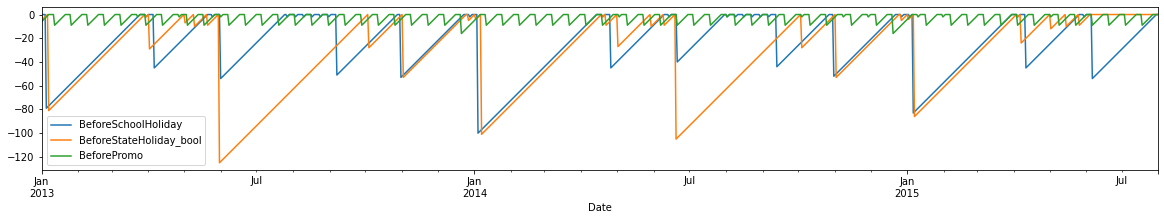

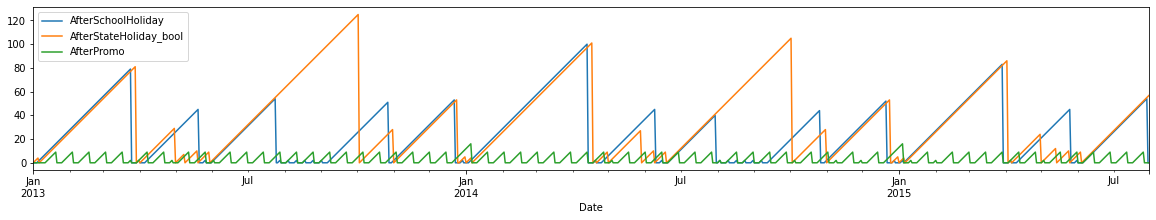

In [ ]:
plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['BeforeSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['BeforeStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['BeforePromo'].plot()
plt.legend()
plt.show()

plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['AfterSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['AfterStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['AfterPromo'].plot()
plt.legend()
plt.show()

### "Suavizado" de columnas temporales

Para el suavizado agarramos una ventana de 7 días y nos fijamos lo que ocurre dentro de esos 7 días, es decir, la cantidad de eventos. Esto se hace recorriendo los datos en forma "backward" (bw) y "forward" (fw).

Se elige para analizar el store nro 1. A continuación vemos sus datos agrupados por fecha

In [ ]:
df_train[df_train[['Store']+columns]['Store'] == 1].sort_values('Date').head(20)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1,0,True,1,0,0,0,0,0,-6
2013-01-02,1,0,False,1,0,0,1,-86,0,-5
2013-01-03,1,0,False,1,0,0,2,-85,0,-4
2013-01-04,1,0,False,1,0,0,3,-84,0,-3
2013-01-05,1,0,False,1,0,0,4,-83,0,-2
2013-01-06,1,0,False,1,0,0,5,-82,0,-1
2013-01-07,1,1,False,1,0,0,6,-81,0,0
2013-01-08,1,1,False,1,0,0,7,-80,0,0
2013-01-09,1,1,False,1,0,0,8,-79,0,0


Para esto se implementa la función "rolling", la cual recibe como paráemtros los días de la ventana, y la mínima cantidad de tiempo para dicha ventana.

In [ ]:
bwd_train = df_train[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd_test = df_test[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd_train.head(20)

Store  SchoolHoliday  StateHoliday_bool  Promo
Store Date                                                      
1     2013-01-01    1.0            1.0                1.0    0.0
      2013-01-02    2.0            2.0                1.0    0.0
      2013-01-03    3.0            3.0                1.0    0.0
      2013-01-04    4.0            4.0                1.0    0.0
      2013-01-05    5.0            5.0                1.0    0.0
      2013-01-06    6.0            6.0                1.0    0.0
      2013-01-07    7.0            7.0                1.0    1.0
      2013-01-08    7.0            7.0                0.0    2.0
      2013-01-09    7.0            7.0                0.0    3.0
      2013-01-10    7.0            7.0                0.0    4.0
      2013-01-11    7.0            7.0                0.0    5.0
      2013-01-12    7.0            6.0                0.0    5.0
      2013-01-13    7.0            5.0                0.0    5.0
      2013-01-14    7.0            4.0                0.0    4.0
      2013-01-15    7.0            3.0                0.0    3.0
      2013-01-16    7.0            2.0                0.0    2.0
      2013-01-17    7.0            1.0                0.0    1.0
      2013-01-18    7.0            0.0                0.0    0.0
      2013-01-19    7.0            0.0                0.0    0.0
      2013-01-20    7.0            0.0                0.0    0.0

In [ ]:
bwd_train.drop('Store',1,inplace=True)
bwd_train.reset_index(inplace=True)
bwd_test.drop('Store',1,inplace=True)
bwd_test.reset_index(inplace=True)

In [ ]:
bwd_train.head(20)

,Store,Date,SchoolHoliday,StateHoliday_bool,Promo
0,1,2013-01-01,1.0,1.0,0.0
1,1,2013-01-02,2.0,1.0,0.0
2,1,2013-01-03,3.0,1.0,0.0
3,1,2013-01-04,4.0,1.0,0.0
4,1,2013-01-05,5.0,1.0,0.0
5,1,2013-01-06,6.0,1.0,0.0
6,1,2013-01-07,7.0,1.0,1.0
7,1,2013-01-08,7.0,0.0,2.0
8,1,2013-01-09,7.0,0.0,3.0
9,1,2013-01-10,7.0,0.0,4.0


In [ ]:
fwd_train = df_train[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()
fwd_test = df_test[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

In [ ]:
fwd_train.head(20)

Store  SchoolHoliday  StateHoliday_bool  Promo
Store Date                                                      
1     2015-07-31    1.0            1.0                0.0    1.0
      2015-07-30    2.0            2.0                0.0    2.0
      2015-07-29    3.0            3.0                0.0    3.0
      2015-07-28    4.0            4.0                0.0    4.0
      2015-07-27    5.0            5.0                0.0    5.0
      2015-07-26    6.0            5.0                0.0    5.0
      2015-07-25    7.0            5.0                0.0    5.0
      2015-07-24    7.0            4.0                0.0    4.0
      2015-07-23    7.0            3.0                0.0    3.0
      2015-07-22    7.0            2.0                0.0    2.0
      2015-07-21    7.0            1.0                0.0    1.0
      2015-07-20    7.0            0.0                0.0    0.0
      2015-07-19    7.0            0.0                0.0    0.0
      2015-07-18    7.0            0.0                0.0    0.0
      2015-07-17    7.0            0.0                0.0    1.0
      2015-07-16    7.0            0.0                0.0    2.0
      2015-07-15    7.0            0.0                0.0    3.0
      2015-07-14    7.0            0.0                0.0    4.0
      2015-07-13    7.0            0.0                0.0    5.0
      2015-07-12    7.0            0.0                0.0    5.0

In [ ]:
fwd_train.drop('Store',1,inplace=True)
fwd_train.reset_index(inplace=True)
fwd_test.drop('Store',1,inplace=True)
fwd_test.reset_index(inplace=True)

In [ ]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [ ]:
df_train = df_train.merge(bwd_train, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_train = df_train.merge(fwd_train, 'left', ['Date', 'Store'], suffixes=['', '_fw'])
df_test = df_test.merge(bwd_test, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df_test = df_test.merge(fwd_test, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [ ]:
df_train.drop(columns,1,inplace=True)
df_test.drop(columns,1,inplace=True)

In [ ]:
df_train.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


In [ ]:
df_train["Date"] = pd.to_datetime(df_train.Date)
df_test["Date"] = pd.to_datetime(df_test.Date)

In [ ]:
df_train.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


Visualizamos los datos nuevamente

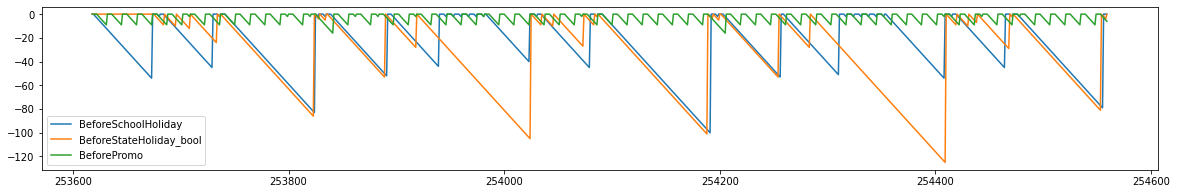

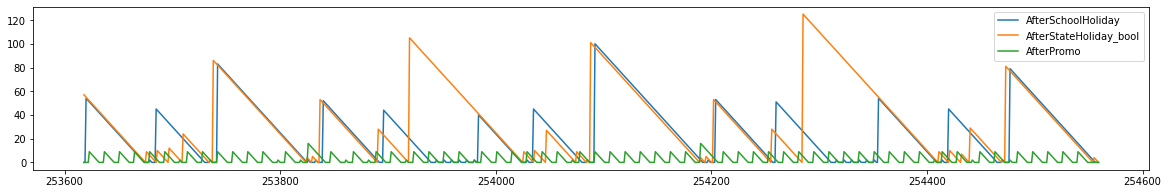

In [ ]:
plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['BeforeSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['BeforeStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['BeforePromo'].plot()
plt.legend()
plt.show()

plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['AfterSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['AfterStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['AfterPromo'].plot()
plt.legend()
plt.show()

### Unimos df preprocesados con joined_test y joined_train

In [ ]:
joined_train = join_df(joined_train, df_train, ['Store', 'Date'])
joined_test = join_df(joined_test, df_test, ['Store', 'Date'])

In [ ]:
joined_train.shape

(1017209, 81)

### Guardamos preprocesado final

In [ ]:
joined_train.to_feather('all_preprocessed_train.fth')

In [ ]:
joined_test.to_feather('all_preprocessed_test.fth')

### Visualización de datos

Observamos los datos agregados pero esta vez en la tabla total. Nuevamente se toma el store 280 para analizar

Text(0.5, 1.0, 'Promo')

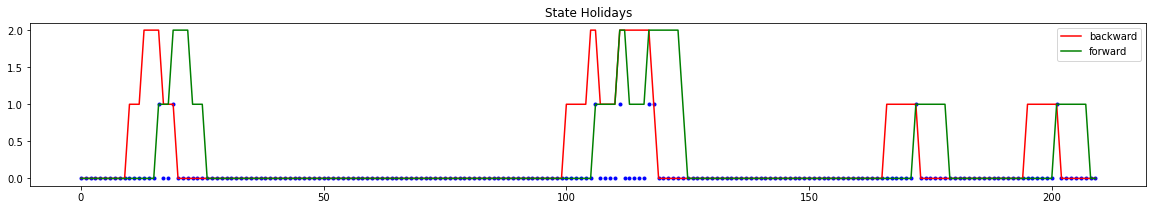

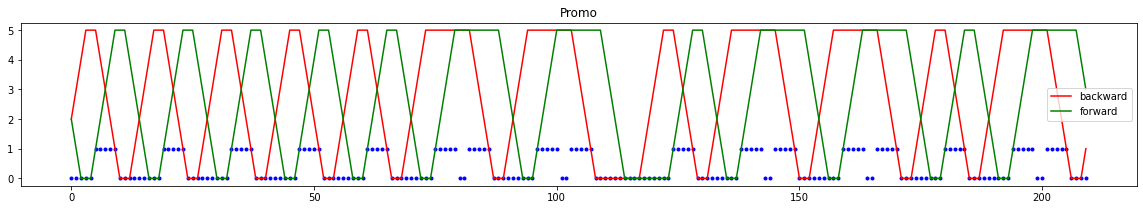

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(joined_train[joined_train['Store']==280]['StateHoliday_bool'].values[100:310]*1.0, c='b', marker='.', linestyle='None')
plt.plot(joined_train[joined_train['Store']==280]['StateHoliday_bool_bw'].values[100:310]*1.0, c='r', label='backward')
plt.plot(joined_train[joined_train['Store']==280]['StateHoliday_bool_fw'].values[100:310]*1.0, c='g', label='forward')
plt.legend()
plt.title('State Holidays')
plt.figure(figsize=(20,3))
plt.plot(joined_train[joined_train['Store']==280]['Promo'].values[100:310]*1.0, c='b', marker='.', linestyle='None')
plt.plot(joined_train[joined_train['Store']==280]['Promo_bw'].values[100:310]*1.0, c='r', label='backward')
plt.plot(joined_train[joined_train['Store']==280]['Promo_fw'].values[100:310]*1.0, c='g', label='forward')
plt.legend()
plt.title('Promo')

In [ ]:
joined_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince,Promo2Since,State,file,week,trend,Date_y,Month_y,Day_y,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,file_y,Max_TemperatureC,...,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,Year_y,Week_y,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Days,Promo2Weeks,StateHoliday_bool,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,9,2008,0,1,1990,-,2008-09-15,1990-01-01,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,Hessen,23,...,8,9,6,3,98,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,21.0,0.00,1.0,Fog,13,Hessen,2015,31,2510,24,9342,25,False,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",2007-11-15,2010-03-29,TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,Thueringen,19,...,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,21.0,0.00,4.0,Fog,309,Thueringen,2015,31,2815,24,1950,25,False,0,0,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",2006-12-15,2011-04-04,NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,NordrheinWestfalen,21,...,6,10,7,4,100,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,21.0,0.00,2.0,Fog,354,NordrheinWestfalen,2015,31,3150,24,1579,25,False,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,c,c,620.0,9,2009,0,1,1990,-,2009-09-15,1990-01-01,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,Berlin,19,...,9,9,7,4,94,61,30,1019,1017,1014,10.0,10.0,10.0,23,16,21.0,0.00,6.0,Sunny,282,Berlin,2015,31,2145,24,9342,25,False,0,0,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,a,a,29910.0,4,2015,0,1,1990,-,2015-04-15,1990-01-01,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,None,8,2,Sachsen,20,...,10,8,6,5,82,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,21.0,0.00,4.0,Sunny,290,Sachsen,2015,31,107,3,9342,25,False,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,a,a,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",2014-06-15,2013-07-29,NW,Rossmann_DE_NW,2013-01-06 - 2013-01-12,63,2013-01-06,1,6,Rossmann_DE,2013-01-06 - 2013-01-12,62,2013-01-06,None,1,6,NordrheinWestfalen,8,...,2,7,5,1,94,87,65,1013,1005,1001,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215,NordrheinWestfalen,2013,1,0,0,0,0,True,0,0,0,0,0,-6,1.0,1.0,0.0,4.0,1.0,1.0
1017205,1112,2,2013-01-01,0,0,0,0,a,1,2013,1,1,1,c,c,1880.0,4,2006,0,1,1990,-,2006-04-15,1990-01-01,NW,Rossmann_DE_NW,2013-01-06 - 2013-01-12,63,2013-01-06,1,6,Rossmann_DE,2013-01-06 - 2013-01-12,62,2013-01-06,None,1,6,NordrheinWestfale

Abrimos los datos guardados

In [ ]:
df_train = pd.read_feather('all_preprocessed_train.fth')
df_test = pd.read_feather('all_preprocessed_test.fth')

In [ ]:
df_train.shape, df_test.shape

((1017209, 81), (41088, 80))

In [ ]:
set(df_train.columns) - set(df_test.columns)

{'Customers', 'Sales'}

Corroboramos que no queden NaN

In [ ]:
(df_train['CompetitionDistance'].isna()).sum()

0

### Variables categóricas y contínuas

A continuación definimos las variables categóricas

In [ ]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 
            'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 
            'CompetitionOpenSinceYear', 'Promo2SinceYear', 
            'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 
            'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 
            'SchoolHoliday_bw']

In [ ]:
DataFrameSummary(df_train[cat_vars]).summary().loc[['uniques', 'types', 'missing']].T

,uniques,types,missing
Store,1115,numeric,0
DayOfWeek,7,numeric,0
Year,3,numeric,0
Month,12,numeric,0
Day,31,numeric,0
StateHoliday,4,categorical,0
CompetitionMonthsOpen,25,numeric,0
Promo2Weeks,26,numeric,0
StoreType,4,categorical,0
Assortment,3,categorical,0


Reemplazamos nulls por "  " en categoricas


In [ ]:
for v in cat_vars: df_train.loc[df_train[v].isnull(), v] = ""
for v in cat_vars: df_test.loc[df_test[v].isnull(), v] = ""

Definimos variables continuas

In [ ]:
contin_vars = ['CompetitionDistance', 
               'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 
               'Precipitationmm', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 
               'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 
               'trend_DE', 'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 
               'Promo', 'SchoolHoliday', 'StateHoliday_bool']

In [ ]:
DataFrameSummary(df_train[contin_vars]).summary().loc[['uniques', 'types', 'missing']].T

,uniques,types,missing
CompetitionDistance,654,numeric,0
Max_TemperatureC,50,numeric,0
Mean_TemperatureC,45,numeric,0
Min_TemperatureC,40,numeric,0
Precipitationmm,40,numeric,0
Max_Humidity,52,numeric,0
Mean_Humidity,71,numeric,0
Min_Humidity,93,numeric,0
Max_Wind_SpeedKm_h,42,numeric,0
Mean_Wind_SpeedKm_h,27,numeric,0


Reemplazamos nulls por 0 en continuas

In [ ]:
for v in contin_vars: df_train.loc[df_train[v].isnull(), v] = 0
for v in contin_vars: df_test.loc[df_test[v].isnull(), v] = 0

### Normalización en continuas y LabelEncode en Categoricas

In [ ]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

In [ ]:
mapper_cat = DataFrameMapper(cat_maps)
_ = mapper_cat.fit(df_train)

In [ ]:
# Assortment es la novena posición en cat_maps
N = 10
print(list(zip(df_train['Assortment'].values[:N], mapper_cat.transform(df_train)[:,9][:N])))
print(list(zip(df_train['Events'].values[:N], mapper_cat.transform(df_train)[:,15][:N])))
print(list(zip(df_train['Year'].values[:N], mapper_cat.transform(df_train)[:,2][:N])))

[('a', 0), ('a', 0), ('a', 0), ('c', 2), ('a', 0), ('a', 0), ('c', 2), ('a', 0), ('c', 2), ('a', 0)]
[('Fog', 0), ('Fog', 0), ('Fog', 0), ('Sunny', 20), ('Sunny', 20), ('Sunny', 20), ('Rain', 10), ('Rain', 10), ('Fog', 0), ('Sunny', 20)]
[(2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2), (2015, 2)]


In [ ]:
mapper_cont = DataFrameMapper(contin_maps)
_ = mapper_cont.fit(df_train)

In [ ]:
N = 10
print(df_train['CompetitionDistance'].values[:N])
print(mapper_cont.transform(df_train)[:, 0][:N])

[ 1270.   570. 14130.   620. 29910.   310. 24000.  7520.  2030.  3160.]
[-0.51104292 -0.59341201  1.00219483 -0.5875285   2.85902934 -0.62400624
  2.16359893  0.22439533 -0.42161363 -0.28864639]


La hacemos con todas ahora

In [ ]:
df_train[cat_vars] = mapper_cat.transform(df_train)
df_test[cat_vars] = mapper_cat.transform(df_test)

In [ ]:
df_train[contin_vars] = mapper_cont.transform(df_train)
df_test[contin_vars] = mapper_cont.transform(df_test)

In [ ]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince,Promo2Since,State,file,week,trend,Date_y,Month_y,Day_y,file_DE,week_DE,trend_DE,Date_DE,State_DE,Month_DE,Day_DE,file_y,Max_TemperatureC,...,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,Year_y,Week_y,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Days,Promo2Weeks,StateHoliday_bool,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
0,0,4,2015-07-31,5263,555,1,1.273237,0,2.144211,2,6,30,30,2,0,-0.511043,9,13,0,1,0,0,2008-09-15,1990-01-01,4,Rossmann_DE_HE,2015-08-02 - 2015-08-08,1.744361,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,1.743049,2015-08-02,None,8,2,Hessen,1.024446,...,0.325047,9,6,3,0.611120,-1.510789,-1.626560,1021,1018,1015,31.0,15.0,10.0,0.148437,-0.147662,21.0,-0.315778,-1.859165,0,13,Hessen,2015,31,2510,24,9342,25,-0.177442,0,0,0.644376,1.072424,0,0,5,0,5,1,0,1
1,1,4,2015-07-31,6064,625,1,1.273237,0,2.144211,2,6,30,30,0,0,-0.593412,11,12,1,13,2,2,2007-11-15,2010-03-29,11,Rossmann_DE_TH,2015-08-02 - 2015-08-08,1.303439,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,1.743049,2015-08-02,None,8,2,Thueringen,0.551899,...,0.170242,9,6,3,0.870277,-0.905024,-1.269897,1021,1019,1017,10.0,10.0,10.0,-0.970080,-0.147662,21.0,-0.315778,-0.493858,0,309,Thueringen,2015,31,2815,24,1950,25,-0.177442,0,0,0.965073,1.072424,0,0,5,0,5,1,0,1
2,2,4,2015-07-31,8314,821,1,1.273237,0,2.144211,2,6,30,30,0,0,1.002195,12,11,1,14,3,2,2006-12-15,2011-04-04,6,Rossmann_DE_NW,2015-08-02 - 2015-08-08,1.832546,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,1.743049,2015-08-02,None,8,2,NordrheinWestfalen,0.788172,...,0.015437,10,7,4,0.870277,-0.980745,-1.320848,1022,1019,1017,31.0,14.0,10.0,-0.970080,-1.165096,21.0,-0.315778,-1.404063,0,354,NordrheinWestfalen,2015,31,3150,24,1579,25,-0.177442,0,0,0.644376,1.072424,0,0,5,0,5,1,0,1
3,3,4,2015-07-31,13995,1498,1,1.273237,0,2.144211,2,6,30,30,2,2,-0.587528,9,14,0,1,0,0,2009-09-15,1990-01-01,0,Rossmann_DE_BE,2015-08-02 - 2015-08-08,0.774331,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,1.743049,2015-08-02,None,8,2,Berlin,0.551899,...,0.479853,9,7,4,0.092806,-0.980745,-1.015137,1019,1017,1014,10.0,10.0,10.0,0.036585,0.700200,21.0,-0.315778,0.416347,20,282,Berlin,2015,31,2145,24,9342,25,-0.177442,0,0,0.965073,1.072424,0,0,5,0,5,1,0,1
4,4,4,2015-07-31,4822,559,1,1.273237,0,2.144211,2,6,30,30,0,0,2.859029,4,20,0,1,0,0,2015-04-15,1990-01-01,9,Rossmann_DE_SN,2015-08-02 - 2015-08-08,1.479808,2015-08-02,8,2,Rossmann_DE,2015-08-02 - 2015-08-08,1.743049,2015-08-02,None,8,2,Sachsen,0.670036,...,0.634658,8,6,5,-1.462136,-1.435069,-1.218945,1020,1018,1016,10.0,10.0,10.0,-0.970080,-0.147662,21.0,-0.315778,-0.493858,20,290,Sachsen,2015,31,107,3,9342,25,-0.177442,0,0,0.644376,1.072424,0,0,5,0,5,1,0,1


In [ ]:
DataFrameSummary(df_train[cat_vars]).summary().loc[['uniques', 'types']]

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_bool_fw,StateHoliday_bool_bw,SchoolHoliday_fw,SchoolHoliday_bw
uniques,1115,7,3,12,31,4,25,26,4,3,4,21,8,12,52,22,6,6,3,3,8,8
types,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric


In [ ]:
df_train.shape

(1017209, 81)

Nos deshacemos de aquellos datos en los que no haya habido ventas

In [ ]:
df_sales = df_train[df_train.Sales!=0]

In [ ]:
df_sales.shape

(844338, 81)

In [ ]:
df_test.reset_index(inplace=True)

In [ ]:
df_sales.reset_index(inplace=True)

### Guardamos datos

In [ ]:
df_sales.to_feather('train_normalized_data.fth')

In [ ]:
df_test.to_feather('test_normalized_data.fth')

Contamos la cantidad de tiendas cerradas

In [ ]:
(df_test['Open'] == 0).sum()

5984

In [ ]:
(df_sales['Open'] == 0).sum()

0

In [ ]:
(df_train['CompetitionDistance'].isna()).sum()

0

## Embedding

Así como existe la capa densa, la capa de BatchNormalization, la capa de DropOut… también existe la capa de embedding.
Esta capa de embedding va a la entrada del modelo, y se trata de una matriz cuyo objetivo es simplificar los inputs del modelo. De esta forma se ingresa a la capa de embedding con un idx, la capa selecciona la columna correspondiente, y devuelve el vector correcto.

La gracia de este procedimiento es que al tener varias variables (categoricas, de bernoulli, algunas continuas normalizada, etc.), nos quedan todas las entradas conectadas completamente y simplificadas ya que se baja la dimensionalidad.


Abrimos los archivos preprocesados

In [ ]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [ ]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [ ]:
uniques

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_bool_fw,StateHoliday_bool_bw,SchoolHoliday_fw,SchoolHoliday_bw
uniques,1115,7,3,12,31,4,25,26,4,3,4,21,8,12,52,22,6,6,3,3,8,8


Definimos un diccionario en el cual se establecen las dimensiones de que va a tener cada embedding de cada variable

In [ ]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 2, 'Year': 2, 'Month': 2,
'Day': 10, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 25, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [ ]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 50 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 2 7 [0 1 2 3 4 5 6]

Year 2 3 [0 1 2]

Month 2 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Day 10 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

StateHoliday 2 4 [0 1 2 3]

CompetitionMonthsOpen 2 25 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]

Promo2Weeks 1 26 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]

StoreType 2 4 [0 1 2 3]

Assortment 3 3 [0 1 2]

PromoInterval 3 4 [0 1 2 3]

CompetitionOpenSinceYear 4 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Promo2SinceYear 4 8 [0 1 2 3 4 5 6 7]

State 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Week 25 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]

Events 4 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

### Variables opcionales

In [ ]:
add_customers = True
log_output = False
output_activation = 'linear'

### Funciones de embedding e inputs para modelo

A continuación se definen dos funciones:     

Por un lado se tiene *get_cat_vars_model*  que recibe como parámetros las variables categóricas, los uniques y el diccionario de las categóricas que se explicó anteriormente. 

Por otro lado se tiene *get_cont_vars_input* que recibe como parámetros lo que concierne a las variables contínuas.

Ambas funciones tienen como objetivo definir los inputs y los outputs de cada layer de embedding que va a tener el modelo, teniendo en cuenta que la salida de una layer va a ser la entrada del siguiente. 

In [ ]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [ ]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

## Configuración de modelo

Se configura un modelo con dos capas densas: una de 1000 neuronas y otra de 500 neuronas. Ambas capas trabajan con una función de activación del tipo 'relu'. Al final se tiene dos outputs (uno de ellos es opcional: customers) que corresponden a una salida lineal. 

Además se establece el factor de regularización L2 que es lambda. Este tiene un valor de 1e-3.

In [ ]:
first_hidden_units = 1000
second_hidden_units = 500
l2_lambda = 1e-3
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)
x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

Dado que se puso como variable opcional la segunda salida del modelo, definimos entonces los outputs con un if:

In [ ]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

Separamos las muestras de la base de datos en train y valid, definiendo como punto de corte la fecha 01/07/2015

In [ ]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


El 96% del dataframe es para entrenamiento y el 4% restante queda para validación

### Agrupamientos finales al dataframe

Agrupamos por la media de los stores

In [ ]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [ ]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Definimos la función sobre la que se va a evaluar la performance del modelo: *root mean square percentage error*

In [ ]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

Se define una métrica

In [ ]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [ ]:
get_metric(df_val, df_val['mean_by_store'])


0.30717460853388645

Juntamos las variables categóricas con las contínuas para definir las entradas de train, valid y test

In [ ]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

Nuevamente, como hay variables opcionales (customers y log_output) se trabaja con un if para definir la señal de salida

In [ ]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
#     y_train = (df_train[y_out_columns].values - y_mean)/y_std
#     y_val = (df_val[y_out_columns].values - y_mean)/y_std
    y_max = df_train[y_out_columns].max().values
    y_train = df_train[y_out_columns].values/y_max
    y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

### Prueba de modelo

Compilamos el modelo. Para ello se introducen hiperparámetros y métricas para evaluar el modelo

In [ ]:
lr = 0.001
model.compile(optimizer=Adam(lr=lr), metrics=['mse', rmspe], loss='mse')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Se define el mejor modelo

In [ ]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

Se realiza un fit

In [ ]:
epochs = 20
batch_size = 256
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=2)

Epoch 1/20
3181/3181 - 140s - loss: 0.0111 - Sales_loss: 0.0014 - Customers_loss: 5.4044e-04 - Sales_mse: 0.0014 - Sales_rmspe: 0.2665 - Customers_mse: 5.4044e-04 - Customers_rmspe: 0.2645 - val_loss: 0.0017 - val_Sales_loss: 0.0010 - val_Customers_loss: 4.0833e-04 - val_Sales_mse: 0.0010 - val_Sales_rmspe: 0.2370 - val_Customers_mse: 4.0833e-04 - val_Customers_rmspe: 0.2383

Epoch 00001: val_Sales_mse improved from inf to 0.00101, saving model to bestmodel.hdf5
Epoch 2/20
3181/3181 - 119s - loss: 0.0014 - Sales_loss: 8.0567e-04 - Customers_loss: 2.8339e-04 - Sales_mse: 8.0567e-04 - Sales_rmspe: 0.2178 - Customers_mse: 2.8339e-04 - Customers_rmspe: 0.2048 - val_loss: 0.0015 - val_Sales_loss: 8.3947e-04 - val_Customers_loss: 3.6506e-04 - val_Sales_mse: 8.3947e-04 - val_Sales_rmspe: 0.1924 - val_Customers_mse: 3.6506e-04 - val_Customers_rmspe: 0.2039

Epoch 00002: val_Sales_mse improved from 0.00101 to 0.00084, saving model to bestmodel.hdf5
Epoch 3/20
3181/3181 - 120s - loss: 0.0011 - S

Ploteamos las métricas para ver el comportamiento

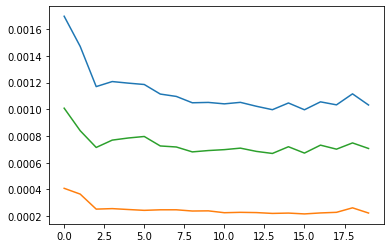

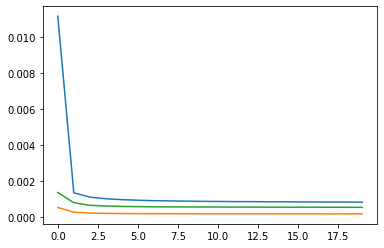

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_Customers_mse'])
plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['Customers_mse'])
plt.plot(history.history['Sales_mse'])

Podemos observar que a medida que aumentan las epochs (veces que se muestran los datos) el error va disminuyendo. Esto es porque se aumenta la cantidad de pasos. 

## Métricas

### Evaluamos modelo

In [ ]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 5s 5ms/step - loss: 0.0010 - Sales_loss: 7.0644e-04 - Customers_loss: 2.2338e-04 - Sales_mse: 7.0644e-04 - Sales_rmspe: 0.1481 - Customers_mse: 2.2338e-04 - Customers_rmspe: 0.1333


[0.0010317288106307387,
 0.0007064368692226708,
 0.00022337937843985856,
 0.0007064368692226708,
 0.14813071489334106,
 0.00022337937843985856,
 0.13331161439418793]

In [ ]:
model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 6s 6ms/step - loss: 9.9662e-04 - Sales_loss: 6.6921e-04 - Customers_loss: 2.2055e-04 - Sales_mse: 6.6921e-04 - Sales_rmspe: 0.1495 - Customers_mse: 2.2055e-04 - Customers_rmspe: 0.1340


[0.0009966244688257575,
 0.0006692077149637043,
 0.00022054693545214832,
 0.0006692077149637043,
 0.14945514500141144,
 0.00022054693545214832,
 0.13402022421360016]

### Hacemos predicts

Nuevamente se trabaja con ifs ya que disponemos de variables que son opcionales (la escala logarítmica y los customers)

In [ ]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std + y_mean)[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std + y_mean)[:,0]
    else:
#         y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
#         y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 10s 8ms/step


In [ ]:
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

0.5828611588895133

Nuevamente sacamos la media de ventas de cada Store

In [ ]:
stores_mean = {}
for store, g_df in df.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

Se agrega la media entonces como predicción de test. Nuevamente se ponen ventas nulas para las tiendas que se encuentran cerradas.

In [ ]:
df_test['Sales'] = df_test['Store'].apply(stores_mean.get)
df_test.loc[df_test['Open'] == 0, 'Sales'] = 0

In [ ]:
sample_csv['Sales'] = df_test['Sales']

Se sube la submision

In [ ]:
sample_csv.to_csv(f'submision_baseline.csv', index=False)

## Submission

Ahora realizamos las predicciones con test y se sube lo obtenido

In [ ]:
sample_csv = pd.read_csv('sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{first_hidden_units}-{epochs}-{batch_size}-{lr}.csv', index=False)

## Analisis de embedding

Dado que el embedding muestra relación entre datos, se procede a graficar.

A continuación se grafican los pesos de los embeddings para analizar aquellos casos en los que se encuentran pocas variables

In [ ]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 2)


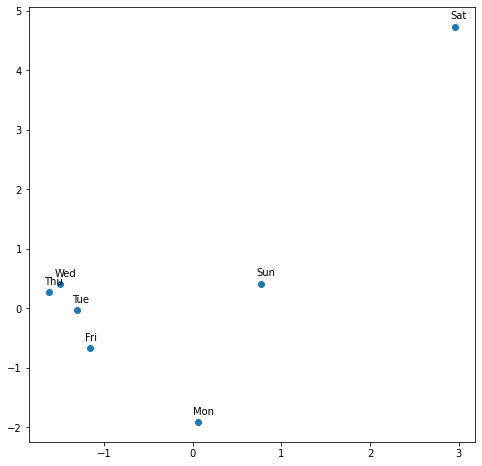

In [ ]:
model.load_weights('bestmodel.hdf5')
plot_embed('DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

Si graficamos los embeddings de los días de la semana vemos que los días hábiles se encuentran bastante cerca, y el resto de los días tienen otro tipo de comportamiento.

(12, 2)


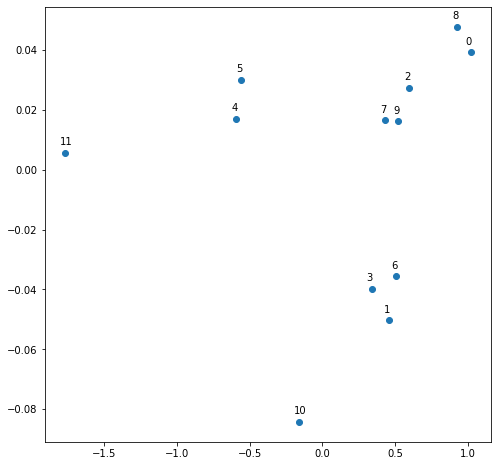

In [ ]:
plot_embed('Month_Embed', list(range(12)))

In [ ]:
cat_vars_embed_outs[2].shape

TensorShape([None, 2])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Year_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_input (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
layer = model.get_layer('DayOfWeek_Embed')
print(layer.input_shape)
print(layer.output_shape)
print(layer.variables)
day_of_week_embedding = layer.get_weights()[0]
day_of_week_embedding
print(day_of_week_embedding.shape)

(None, 1)
(None, 1, 2)
[<tf.Variable 'DayOfWeek_Embed/embeddings:0' shape=(7, 2) dtype=float32, numpy=
array([[-0.06131281,  1.9153717 ],
       [ 1.3029325 ,  0.03428087],
       [ 1.5004903 , -0.4065249 ],
       [ 1.618711  , -0.26259708],
       [ 1.1575167 ,  0.6741691 ],
       [-2.957564  , -4.7286053 ],
       [-0.7720979 , -0.4081697 ]], dtype=float32)>]
(7, 2)


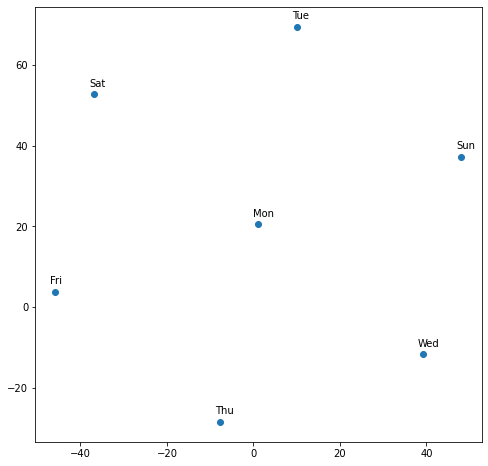

In [ ]:
tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)
Y = tsne.fit_transform(day_of_week_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [ ]:
cat_vars

['Store',
 'DayOfWeek',
 'Year',
 'Month',
 'Day',
 'StateHoliday',
 'CompetitionMonthsOpen',
 'Promo2Weeks',
 'StoreType',
 'Assortment',
 'PromoInterval',
 'CompetitionOpenSinceYear',
 'Promo2SinceYear',
 'State',
 'Week',
 'Events',
 'Promo_fw',
 'Promo_bw',
 'StateHoliday_bool_fw',
 'StateHoliday_bool_bw',
 'SchoolHoliday_fw',
 'SchoolHoliday_bw']

In [ ]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [ ]:
submodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Year_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_input (InputLayer)        [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
submodel.save('embeddings_model.hdf5')

## RESULTADO

Se realizó el submit a la competencia de Kaggle y se obtuvo el siguiente resultado: 

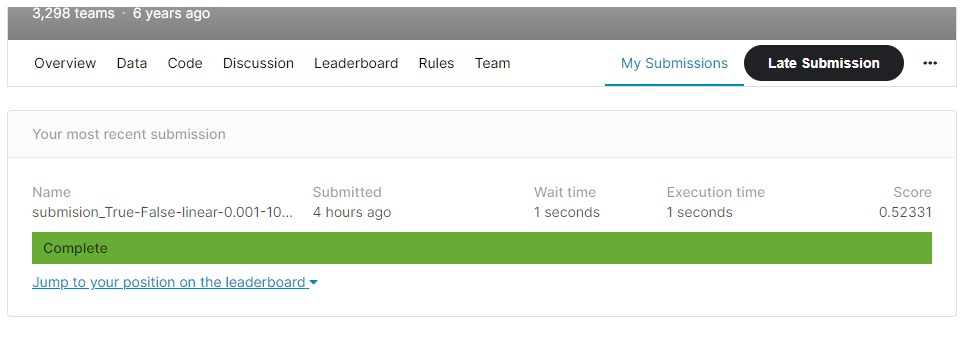

## CONCLUSIONES

Como conclusión se puede decir que los procedimientos para realizar predicciones sobre bases de datos son muy amplios. En este caso se procedió a comentar el modelo otorgado por la cátedra. Sin embargo, la performance del submit no dio un valor tan bueno como el esperado. Esto se puede modificar de varias formas:    

Por un lado no se optó por utilizar ninguno de los datos externos para el entrenamiento de la red neuronal. Esto podría haber mejorado en forma significativa los resultados ya que agrega más variables de estudio para el algoritmo.

Por otro lado, se cuenta con variables opcionales: customers y la salida en escala logarítmica. Jugando con estos valores es probable que se obtengan resultados diferentes. 

Además se podría haber jugado también con los hiperparámetros: cantidad de neuronas de la red, el valor de regularización L2, la cantidad de epochs, de batch_size, entre otros. 

También se podría haber agregado un dropout.

Por último, en un análisis más profundo, se podría haber evaluado alguna métrica como el índice de Jaccard, entre los datos de los clusters que quedaron.

Sin embargo se aprendió que la técnica de embedding resulta muy eficiente a la hora de trabajar con bases de datos, y que combinarla con otro modelo resulta beneficioso.


